# Stock Market Predictor
The code below is used to extract data from a certain stock and apply regression algorithms on these values.

It is based on: https://www.youtube.com/watch?v=JcI5Vnw0b2c&list=PLQVvvaa0QuDfKTOs3Keq_kaG2P55YRn5v&index=2

Author:
fanconic
tria124

## Import Libraries

In [1]:
import numpy as np
import yfinance as yf
import pandas as pd
import math
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, scale
from sklearn.model_selection import train_test_split as tts
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import median_absolute_error

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Get Stock Data
We use the Yahoo Finance API to get our stock market data.
we will track the UBS stock data.

In [2]:
tickerData = yf.Ticker("NOVN")
df = tickerData.history(period='1d', start="2015-1-1", end="2020-04-20")

## Feature Engineering

In [3]:
# Create some extra features
df['hl_pct'] = (df['High'] - df['Close']) / df['Close']
df['delta_pct'] = (df['Close'] - df['Open']) / df['Close']

# Moving Average (Weekly, Monthly, Quarterly)
df["5d_uma"] = df["Close"].rolling(5).mean()
df["20d_uma"] = df["Close"].rolling(20).mean()
df["60d_uma"] = df["Close"].rolling(60).mean()

# Exponential Moving Average
df["5d_ema"] = df["Close"].ewm(span=5).mean()
df["20d_ema"] = df["Close"].ewm(span=20).mean()
df["60d_ema"] = df["Close"].ewm(span=60).mean()

In [4]:
# Decide how many days ahead our algorithm should predict
future_forecast = 1 # days into the future
df["label"] = df["Close"].shift(-future_forecast)
df.dropna(inplace=True)

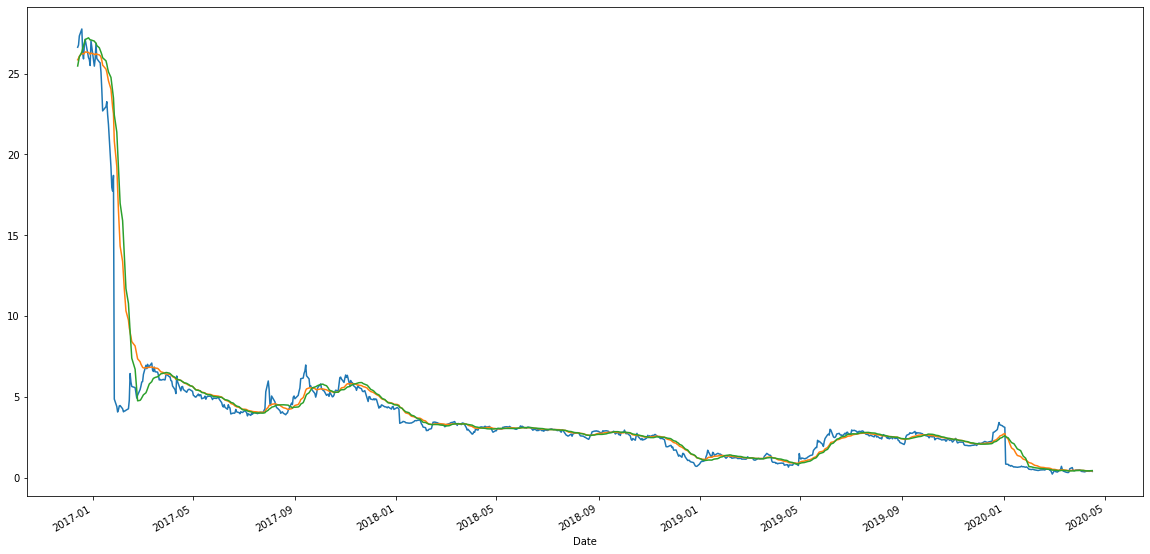

In [5]:
fig = plt.figure(figsize=(20,10))
df["Close"].plot()
df["20d_ema"].plot()
df["20d_uma"].plot()

## Create Machine Learning Training data
We now create the machine learning training data. our goal is to predict the prices ten days in advanced.

In [6]:
# Training data
X = df.drop(["label"], axis = 1)
#X = pd.DataFrame(scale(X))
y = df["label"]


test_size = 20
X_test = X[-test_size:]
y_test = y[-test_size:]
X = X[:-test_size]
y = y[:-test_size]

# Time Series Split:
tscv = TimeSeriesSplit(n_splits = 10, max_train_size=None)

## Model
We choose a regression model which gives us the best confidence score.

In [7]:
#model = RandomForestRegressor(n_estimators=200, random_state=42)
from sklearn.linear_model import Lasso, Ridge
model = LinearRegression()

for train_index, val_index in tscv.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    print("MAE: ", median_absolute_error(y_val, y_pred))
    print("R² Value: ", model.score(X_val, y_val), "\n")

MAE:  0.16653433465743595
R² Value:  0.6160547180774542 

MAE:  0.23385553454963093
R² Value:  0.5424756754260707 

MAE:  0.13645158794420942
R² Value:  0.9273367896811814 

MAE:  0.13405183168422297
R² Value:  0.0037958092083005823 

MAE:  0.09527140959102254
R² Value:  0.13862666735019447 

MAE:  0.1707068655847932
R² Value:  0.6049797205482084 

MAE:  0.12145817534879622
R² Value:  -2.3137928159648355 

MAE:  0.08200813560409337
R² Value:  0.9142218872552016 

MAE:  0.061804053919077284
R² Value:  0.8436561281008433 

MAE:  0.07813111170425135
R² Value:  0.8834027953059871 



In [8]:
model.fit(X, y)
y_pred = model.predict(X_test)
print("MAE: ", median_absolute_error(y_test, y_pred))
print("R² Value: ", model.score(X_test, y_test))

MAE:  0.04729038489595014
R² Value:  -2.6106053686589434


## Plot Results
With the plots we want ot have alook at the historical plots, as well as the future predictions

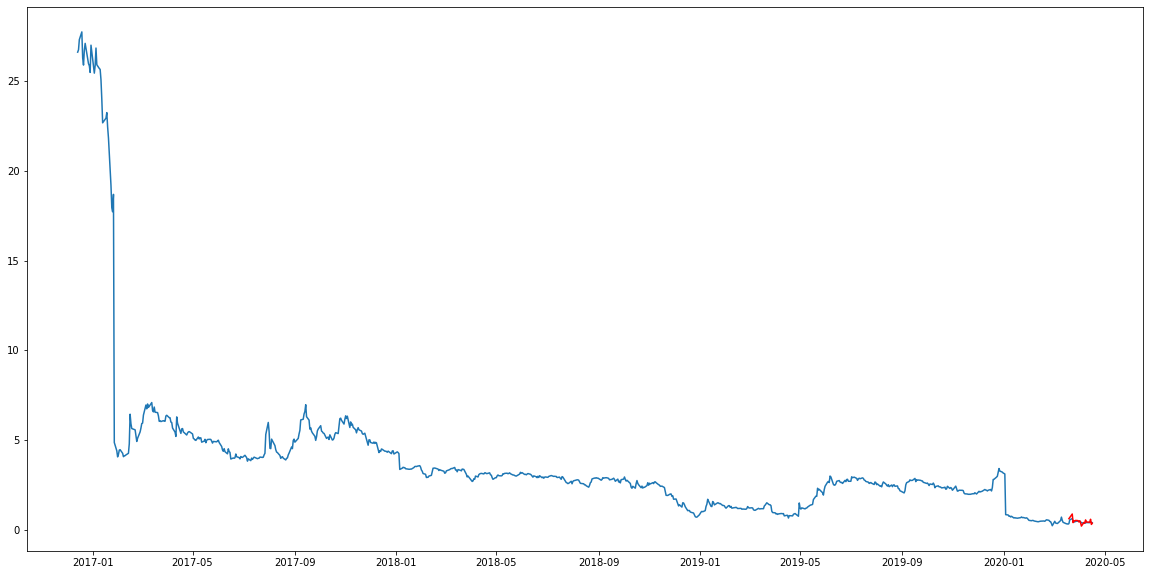

In [9]:
preds = np.empty(len(df))
preds[:] = np.nan
preds[-test_size:] = y_pred
df["preds"] = preds

fig = plt.figure(figsize=(20,10))
plt.plot(df["Close"], label="reality")
plt.plot(df["preds"], color="r", label="prediction")
plt.show()

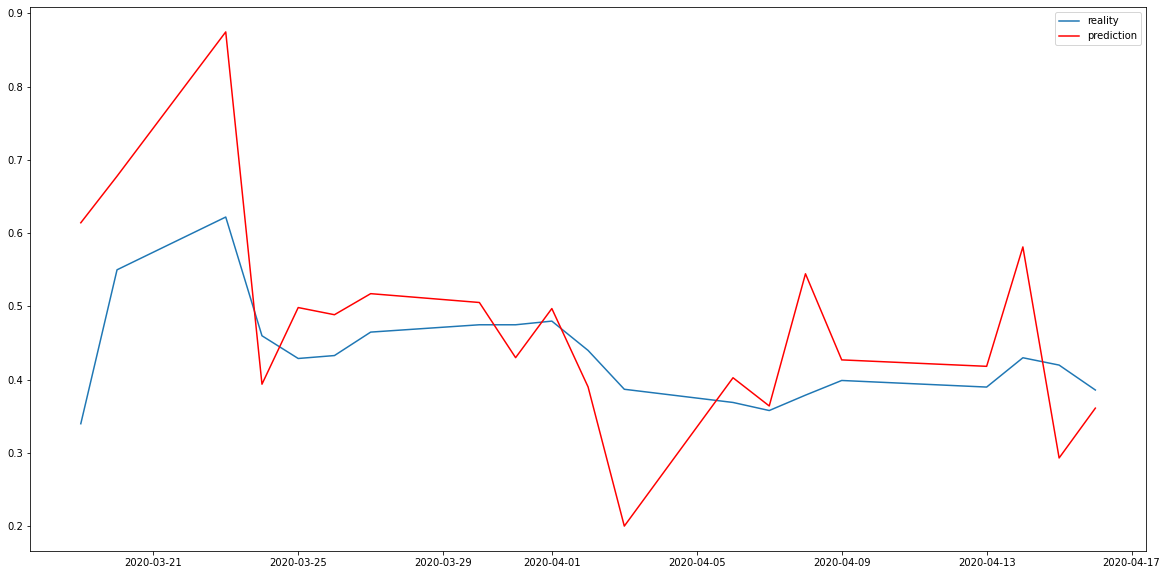

In [10]:
fig = plt.figure(figsize=(20,10))
plt.plot(df["Close"][-test_size:], label="reality")
plt.plot(df["preds"][-test_size:], color="r", label="prediction")
plt.legend()
plt.show()
del df["preds"]

## Trading Simulation
As trading strategy we will set some boundaries, as well as safety ratios.Let's assume, we will have 1000 USD to trade, as this seems a fair ammount to get started. We assume a transaction percentage cost of 5 USD per transaction. Furthermore, let's assume that we have 500 USD free cash to buy additional stocks.

Our goal is to beat the following two metrics
 - We want to try to make more than if we would have not invested NOTHING anything in this UBS stocks: Hence, we need more than 1000 USD at the end of the test period.
 - The second goal is to beat the base line, if we would have invested EVERYTHING in UBS stocks from the beginning period. 
 
You can the two charts we want to beat below:

Our test data will be everything as of January 2020 (This will make it pretty difficult because of the COVID-19 crisis).

In [11]:
original_investment = 2000.0
original_reserves = 100

money_active = original_investment
money_reserve = original_reserves
stocks_active = 0
money_gained = 0.0
transaction_cost = 10
investment_df = pd.DataFrame(index=df[-test_size:].index)

In [12]:
def buy(stock_price, n_stocks = None, transaction_cost = transaction_cost):
    """
    This function simulates a buy, including the costs of transaction.
    It adjustes in the function the global variables money_active and stocks_active
    params:
        stock_price: Price of the stocks to be bought.
        n_stocks (default value None): number of stocks to be bought.
        transaction_cost (default value = 5): cost.
    returns:
        ammount invested
        ammount leftover
        number of bought stocks
    """
    global money_active
    global money_reserve
    global stocks_active

    # deduct transaction cost
    money_active -= transaction_cost
    
    # Check if we still have money left
    if money_active < 0:
        if money_reserve > 0:
            money_reserve + money_active
            money_active = 0
        else:
            raise NameError('No more money!')
    
    # Check if ammount is feasible
    if n_stocks is None:
        n_stocks = money_active // stock_price
    else:
        assert n_stocks <= money_active // stock_price
    
    # Calculate investments
    money_active -= n_stocks * stock_price
    stocks_active += n_stocks
    

def sell(stock_price, n_stocks = None, transaction_cost = transaction_cost):
    """
    This function simulates a sell including the cost of transaction.
     It adjustes in the function the global variables money_active and stocks_active
    params:
        stock_price: Price of the stocks to be sold.
        n_stocks (default value None): number of stocks to be sold.
        transaction_cost: transaction cost.
    """
    
    global money_active
    global money_reserve
    global stocks_active
    
    # deduct transaction cost
    money_active -= transaction_cost
    
    # Check if we still have money left
    if money_active < 0:
        if money_reserve > 0:
            money_reserve + money_active
            money_active = 0
        else:
            raise NameError('No more money!')
          
    # Check if ammount is feasible
    if n_stocks is None:
        n_stocks = stocks_active
    else:
        assert n_stocks <= stocks_active
        
    # Calculate investments
    stocks_active -= n_stocks
    money_active += n_stocks * stock_price

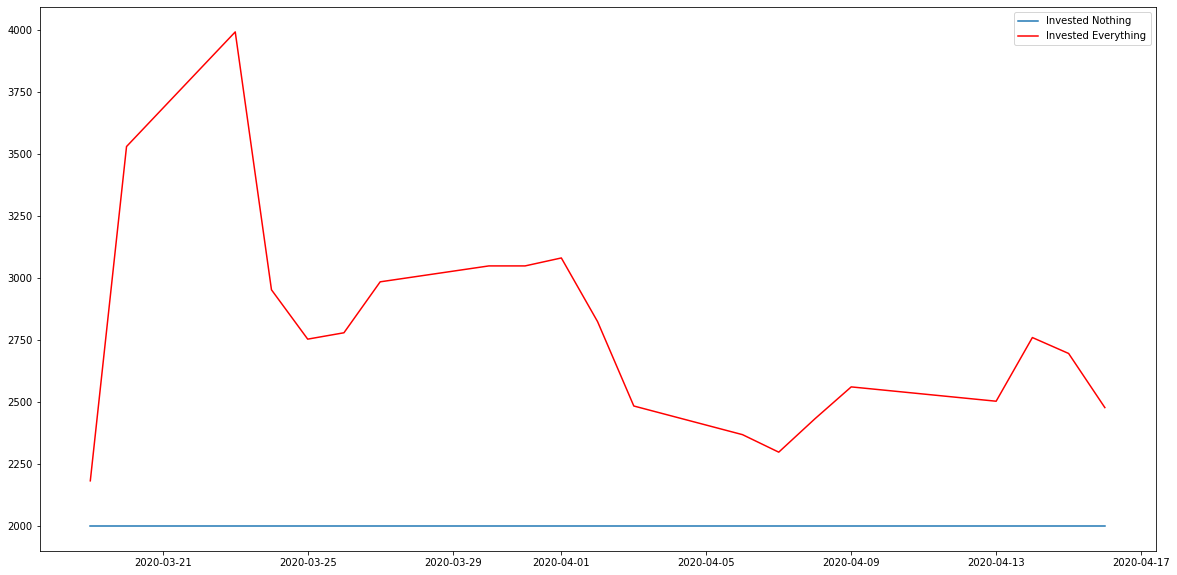

In [13]:
# No investment
const = np.ones(len(df[-test_size:]))*money_active
investment_df["nothing"] = const

# All investment
buy(df["Open"][-test_size])
investment_df["all"] = money_active + stocks_active * df["Close"][-test_size:]
sell(df["Close"][-1])

fig = plt.figure(figsize=(20,10))
plt.plot(investment_df["nothing"], label= "Invested Nothing")
plt.plot(investment_df["all"], color="r", label="Invested Everything")
plt.legend()
plt.show()

In [14]:
full_investment = money_active
print(full_investment)
money_active = original_investment
money_reserve = original_reserves
stocks_active = 0

2477.734


## Simple Trading Strategy
Our first simple trading strategy is that if our regression model expects the closing value of the next day be higher including the transaction costs, then we will buy. If the regression model expects the value to drop more the next day than just the transaction cost, then we will sell.

In [15]:
def simple_strategy(model, x, transaction_cost = transaction_cost):
    """
    Simple trading strategy as mentioned above. Makes actions {sell, buy, stay}
    params:
        model: regression model
        x: feature of one day
        transaction_cost: flat fee for transaction
    """
    global stocks_active
    global money_active
    
    open_today = x["Open"]
    close_next_day =  model.predict(x.values.reshape(1, -1))
    
    # What is the value today and the value tomorrow?
    buy_sell_pct = 0.5
    possible_extra_stocks =  (buy_sell_pct * money_active) // open_today
    stocks_value_next_day_buy = close_next_day * (stocks_active + possible_extra_stocks)
    stocks_value_next_day_sell = close_next_day * stocks_active
    stocks_value_today = open_today*stocks_active
    
    if  stocks_value_next_day_buy + (1-buy_sell_pct)*money_active - transaction_cost > stocks_value_today + money_active:
        # Buy as many possible stocks with 50% of the cashflow on buy signal
        buy(open_today, n_stocks = possible_extra_stocks)
        print('%-10s %-25s %s' % ("BUY", money_active, stocks_active))
    
    elif stocks_value_next_day_sell + money_active  < stocks_value_today + money_active - transaction_cost:
        # Sell half the stocks if sell signal
        n_stocks = int(buy_sell_pct*stocks_active)
        sell(open_today, n_stocks = n_stocks)
        print('%-10s %-25s %s' % ("SELL", money_active, stocks_active))
        
    else:
        print('%-10s %-25s %s' % ("STAY", money_active, stocks_active))
        pass

In [16]:
investment_df["simple_strategy"] = np.zeros(len(investment_df))

for index, row in X_test.iterrows():
    simple_strategy(model, row)
    investment_df["simple_strategy"][index] = money_active + stocks_active * row["Close"]

BUY        990.25                    3225.0
BUY        485.22999999999996        4159.0
BUY        232.78999999999994        4599.0
SELL       1358.4959999999999        2300.0
BUY        669.5959999999999         3850.0
BUY        325.1959999999999         4610.0
BUY        152.7459999999999         4971.0
BUY        66.64099999999989         5126.0
SELL       1286.8809999999999        2563.0
BUY        633.6809999999999         3903.0
SELL       1540.6509999999998        1952.0
SELL       1989.3709999999999        976.0
BUY        984.9489999999998         3693.0
SELL       1657.9689999999998        1847.0
BUY        819.1249999999999         4195.0
BUY        399.6249999999999         5245.0
BUY        190.19499999999988        5763.0
BUY        85.33099999999988         6005.0
SELL       1486.2709999999997        3003.0
SELL       2076.671                  1502.0


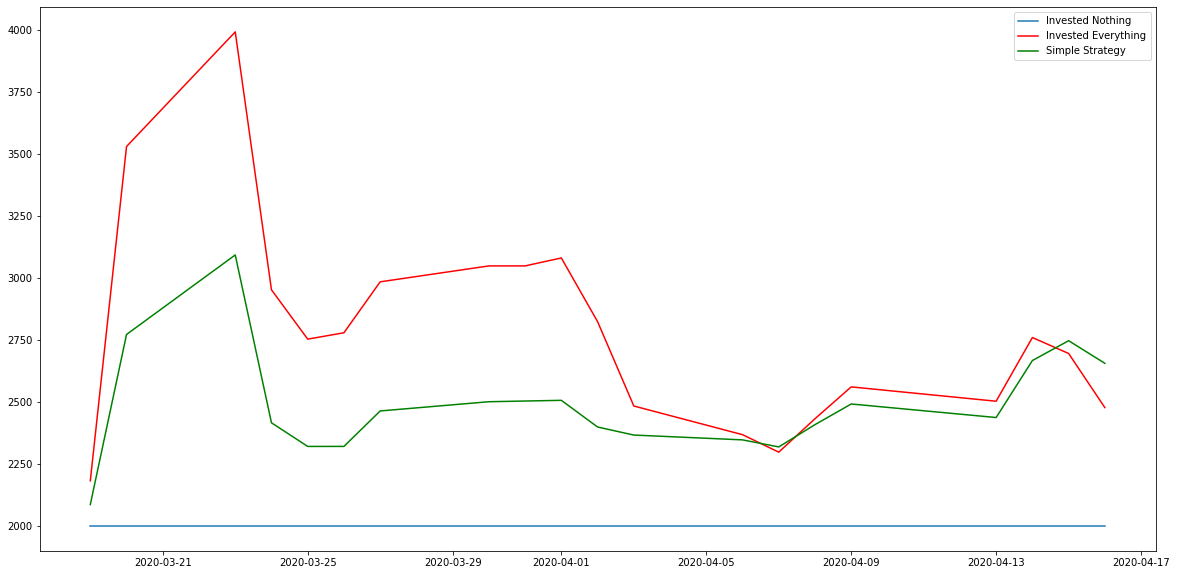

In [17]:
fig = plt.figure(figsize=(20,10))
plt.plot(investment_df["nothing"], label= "Invested Nothing")
plt.plot(investment_df["all"], color="r", label="Invested Everything")
plt.plot(investment_df["simple_strategy"], color="g", label="Simple Strategy")
plt.legend()
plt.show()

In [18]:
sell(df["Close"][-1])
money_active

2646.4429999999998

In [19]:
print("Money win/loss compared to no investment: ", money_active - original_investment)
print("Money win/loss compared to full investment: ", money_active - full_investment)

Money win/loss compared to no investment:  646.4429999999998
Money win/loss compared to full investment:  168.70899999999983
